<a href="https://colab.research.google.com/github/Dmitriycyber/CNN/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание

В этом домашнем задании вам предстоит обучить DCGAN для генерации лиц и изучить латентное пространство. Модель DCGAN аналогична той, которая использовалась на лекции. Рекомендуем вам подробно ознакомится с приведенным кодом, чтобы лучше понимать как все устроено “изнутри”.


В качестве напоминания приводим ниже иллюстрацию архитектуры ([источник](https://github.com/znxlwm/tensorflow-MNIST-GAN-DCGAN) иллюстрации).

![alt text](https://github.com/znxlwm/tensorflow-MNIST-GAN-DCGAN/raw/master/tensorflow_DCGAN.png)

In [1]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import time
from IPython import display
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import UpSampling2D, Conv2D, BatchNormalization, LeakyReLU, Conv2DTranspose, Reshape, Flatten


cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
init = RandomNormal(mean=0.0, stddev=0.02)

In [2]:
# модель незначительно отличается от представленной на лекции
# добавлено сохранение весов, восстановление обучения, немного упрощен код

class DCGAN(tf.keras.Model):
    def __init__(self, image_size, output_path, num_channels=1, z_dim=100,
                 G_h_size=128, D_h_size=128):
        """
        image_size -- размер стороны квадратной картинки
        output_path -- путь для сохранения артефактов обучения. в корне -- картинки с разных итераций, в папке model -- модель
        num_channels -- количество каналов изображения
        z_dim -- размерность латентного вектора
        G_h_size -- минимальный размер фильтров с сверточных слоях генератора
        D_h_size -- минимальный размер фильтров с сверточных слоях дискриминатора
        """
        super().__init__()
        self.image_size = image_size
        self.num_channels = num_channels
        self.z_dim = z_dim

        self.multiply = int(np.log2(self.image_size / 8)) # столько раз нужно применить апсемплинг или даунсемплинг
                                                          # чтобы из (4,4) получить (image_size/2, image_size/2) и наоборот
                                                
        self.output_path =  Path(output_path)
        (self.output_path / "model").mkdir(exist_ok=True)

        self.G_h_size = G_h_size
        self.D_h_size = D_h_size

        self.generator = self._build_generator()
        self.discriminator = self._build_discriminator()

        self.optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5, beta_2=0.999)
         
        self.gen_loss_hist = []
        self.disc_loss_hist = []
        self._vis_h = 5
        self._vis_w = 5
        self._vis_noise = np.random.normal(0, 1, (self._vis_h* self._vis_w, self.z_dim)).astype(np.float32)
        self.start_iteration = 0

    def discriminator_loss(self, real_output, fake_output):
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    def generator_loss(self, fake_output):
        return cross_entropy(tf.ones_like(fake_output), fake_output)
    
    def _conv_bn_leaky(self, kernel_size, channels, stride=1):
        """
        Этот блок мы будем часто использовать -- поэтому вынесем его в отдельную функцию

        Он содержит Conv + BatchNorm + LeakyReLU

        При указании stride=2 -- уменьшит размер в два раза.
        """
        model = tf.keras.Sequential()
        model.add(Conv2D(channels,
                         kernel_size=kernel_size, padding="same",
                         use_bias=False, kernel_initializer=init,
                         strides=(stride, stride))) # use_bias=False, т.к. BatchNorm и так вычтет среднее
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        return model
        

    def _build_generator(self):
        """
        Генератор должен превращать вектор длины self.z_dim в 
        картинку image_size x image_size x num_channels

        """
        
        model = tf.keras.Sequential()
        # для начала сделаем вектор -- трехмерным тензором м помощью Reshape
        model.add(Reshape((1, 1, self.z_dim), input_shape=(self.z_dim,)))

        # Превратим его в тензор размера (4, 4, self.G_h_size * 2**self.multiply)
        model.add(Conv2DTranspose(self.G_h_size * 2**self.multiply,
                                  kernel_size=4, use_bias=False, 
                                  kernel_initializer=init))
        model.add(BatchNormalization())
        model.add(LeakyReLU())

        
        for i in range(self.multiply):
            model.add(UpSampling2D()) # увеличиваем картинку
            model.add(self._conv_bn_leaky(4, self.G_h_size * 2**self.multiply // 2**(i+1))) # уменьшаем количество фильтров в два раза
        
        assert model.output_shape[1:] == (self.image_size // 2, self.image_size // 2, self.D_h_size), f"{model.output_shape, self.D_h_size}"
        
        model.add(UpSampling2D())
        model.add(Conv2D(self.num_channels,
                         kernel_size=4, strides=(1, 1),
                         activation="tanh", padding="same", 
                         kernel_initializer=init))
        return model

    def _build_discriminator(self):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.InputLayer(
            input_shape=((self.image_size, self.image_size, self.num_channels))))
        model.add(self._conv_bn_leaky(kernel_size=4, 
                                      channels=self.D_h_size,
                                      stride=2,
                                      ))
        
        for i in range(self.multiply):
            model.add(self._conv_bn_leaky(kernel_size=4, 
                                          channels=self.D_h_size * (2 ** (i+1)),
                                          stride=2)) # количество фильтров увеличивается, размер уменьшается
        assert model.output_shape[1:] == (4, 4, self.D_h_size * 2**self.multiply), f"{model.output_shape}"
        model.add(Conv2D(1, kernel_size=4, kernel_initializer=init, use_bias=False)) # без активации !
        model.add(Flatten())
        return model
    
    @tf.function
    def train_step(self, images):
        """
        Шаг обучения как в прошлом уроке
        """
        noise = tf.random.normal([tf.cast(images.shape[0], tf.int32), self.z_dim])
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)

            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)
            
        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))
        return gen_loss, disc_loss

    def save_imgs(self, epoch):
        """
        Сохранение промежуточных картинок на диск
        """
        gen_imgs = self.generator(self._vis_noise, training=False)
        gen_imgs = 0.5 * gen_imgs + 0.5
        fig, axs = plt.subplots(self._vis_h, self._vis_w, figsize=(6,6))
        cnt = 0
        for i in range(self._vis_h):
            for j in range(self._vis_w):
                if self.num_channels == 1:
                    axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                else:
                    axs[i, j].imshow(gen_imgs[cnt, :, :, :])
                axs[i, j].axis('off')
                cnt += 1
        fig.savefig(self.output_path / f"{epoch}.png")
        plt.show()
    
    def train(self, dataset, num_iters=2000, show_every=25):
        """
        Цикл обучения
        """
        start = time.time()
        iters = self.start_iteration
        for image_batch in dataset:
            print(".", end='')
            gen_loss, disc_loss = self.train_step(image_batch)
            
            self.disc_loss_hist.append(disc_loss.numpy())
            self.gen_loss_hist.append(gen_loss.numpy())    
            
            if iters % show_every == 0:
                display.clear_output(wait=True)
                plt.figure()
                plt.plot(self.disc_loss_hist, label="Discriminator loss")
                plt.plot(self.gen_loss_hist, label="Generator loss")
                plt.legend(loc="best")
                plt.figure()
                self.save_imgs(f"{iters}")
                self.save_weights(str(self.output_path / "model" / "dcgan_model"), save_format='tf')
                
                print(f"\n{iters}/{num_iters}")
                print(f'Time elapsed from start {time.time() - start} sec')
                
            iters += 1
            if iters > num_iters:
                print(f'Finished. Time elapsed from start {time.time() - start} sec')
                return
        


## Загрузка датасета

In [3]:
! pip install gdown
import gdown

url = 'https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk'
output = '/tmp/UTKFace.tar.gz'
gdown.download(url, output, quiet=False)
! tar -xzf /tmp/UTKFace.tar.gz -C /tmp/

Downloading...
From: https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk
To: /tmp/UTKFace.tar.gz
107MB [00:01, 94.6MB/s] 


## Задание 1. Создание генераторов данных

Реализуйте генератор изображений с указанными ниже BATCH_SIZE и IMAGE_SIZE. Используйте для этого ImageDataGenerator, flow_from_dataframe или flow_from_directory. Данные расположены в папке "/tmp/UTKFace". Классы в этом задании нам не нужны.

*Интенсивности картинок должны быть нормализованы от -1 до 1.*

In [4]:
BATCH_SIZE = 128
IMAGE_SIZE = 64

In [5]:
from pathlib import Path
import os
os.listdir("/tmp/UTKFace/")
data_folder = Path("/tmp/UTKFace/")
filenames = list(map(lambda x: x.name, data_folder.glob('*.jpg')))

data = {"img_name": filenames}
df = pd.DataFrame(data) # формирую датафрэйм с изображениями 
df.head()

,img_name
0,49_1_1_20170112235151889.jpg.chip.jpg
1,51_0_0_20170109012546903.jpg.chip.jpg
2,20_0_0_20170116205525001.jpg.chip.jpg
3,53_0_0_20170113184718824.jpg.chip.jpg
4,10_1_0_20170109205141310.jpg.chip.jpg


(200, 200, 3)


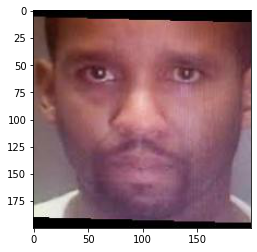

In [6]:

def show_face(image):
    """
    функция демонстрации изображений
    
    """ 
    print(image.shape)
    plt.imshow(image)

row = df.iloc[np.random.randint(len(df))]
img = plt.imread(str(data_folder / row["img_name"]))

show_face(img)

In [7]:
# < YOUR CODE STARTS HERE >
# создание генератора изображений из датафрэйма 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_gen = ImageDataGenerator(rescale=1./255) 

image_generator = image_gen.flow_from_dataframe(batch_size=BATCH_SIZE,
                                                    directory=str(data_folder),
                                                    class_mode = None,
                                                    dataframe=df,
                                                    x_col='img_name',
                                                    shuffle=True,
                                                    target_size=(IMAGE_SIZE,IMAGE_SIZE))


# < YOUR CODE ENDS HERE >

Found 23708 validated image filenames.


Shape test passed


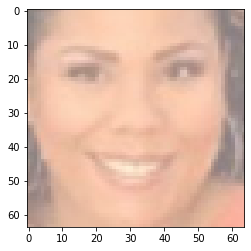

In [9]:
# тест генератора данных
sample = next(image_generator)
assert sample.shape == (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3), f"Размер батча должен быть: {(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3)}.  Получен {sample.shape}"
print("Shape test passed")
# если препроцессинг правильный, то картинка ниже имеет реалистичные цвета и matplotlib не ругается
plt.imshow((sample[5] + 1.) / 2)

In [10]:
print(sample[100].max(), sample[100].min())

1.0 0.0


## Задание 2. Обучение DCGAN

В этом задании вам нужно просто запустить обучение GAN. С указанными параметрами оно займет около часа.

Предварительно заманутите Google Drive, для сохранения промежуточных результатов и весов модели.

In [11]:
# Для того, чтобы сохранять прогресс и веса модели, будем использовать google drive -- так модель не потеряется
# и в случае отключения Colab в сможете продолжить обучение.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
output = Path("/content/drive/My Drive/gan_utk_32")
output.mkdir(exist_ok=True)
(output / "model").mkdir(exist_ok=True)

gan = DCGAN(image_size=IMAGE_SIZE, num_channels=3, output_path=output, 
           z_dim=100, D_h_size=128, G_h_size=128)

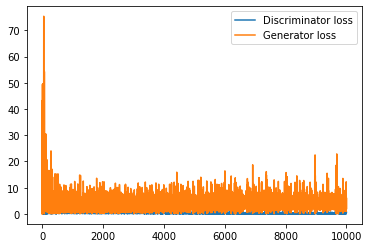

<Figure size 432x288 with 0 Axes>

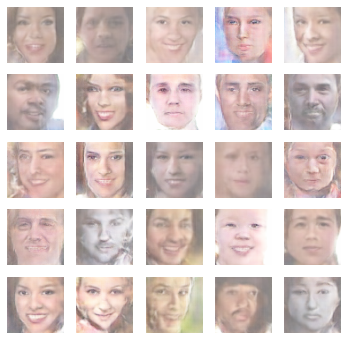


10000/10000
Time elapsed from start 8452.676279067993 sec
Finished. Time elapsed from start 8452.676317691803 sec


In [13]:
images = list(output.glob("*.png"))
if images: # если папка не пуста, то продолжим обучение с последней итерации
    iters = list(map(lambda x: int(x.name.split(".")[0]), images))
    last_iter = sorted(iters)[-1]
    gan.start_iteration = last_iter
    print(f"Resuming model from {last_iter} iteration")
    
gan.train(image_generator, 10000, 50)

После того как модель обучена, можно посмотреть какие лица она научилась генерировать!

In [14]:
def generate_data(latent_vector, generator):
    """
    Для того чтобы сгенерировать объект нам нужен генератор и латентный вектор
    """
    gen_imgs = generator(latent_vector, training=False)
    gen_imgs = 0.5 * gen_imgs + 0.5
    return gen_imgs

Вектор:  [ 0.51379615 -0.6849994   0.6614253  -0.00833337 -0.14982833 -0.5396769
 -1.0265772  -0.01039999 -0.581548   -0.34879574]


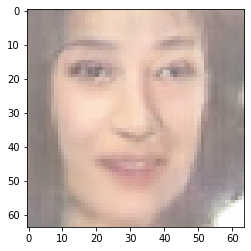

In [22]:
v1 = tf.random.normal([1, 100]) # случайный вектор
print("Вектор: ", v1.numpy()[0, :10]) # распечатаем 10 первых элементов

face_gen = generate_data(v1, gan.generator)[0]
_ = plt.imshow(face_gen) # сгенерированное лицо, попробуйте сгенерировать несколько. 
                                                    # они должны получаться достаточно реалистичными

## Задание 3. Поиск вектора улыбки

В этом задании вам предстоит найти “вектор улыбки” и доказать что он таковым является. 

Что это означает? Как мы уже знаем, GAN генерирует данные из случайных векторов из определенного распределения. Такие вектора образуют латентное пространство. Напомню аналогию с бегунками в компьютерной игре - в этом случае латентное пространство задается всеми положениями бегунков, которым соответствуют реалистичные лица. 

В нашем случае GAN тоже выучил нечто подобное, ведь ему хватает 100 чисел, чтобы создать лицо -- это и есть его бегунки. Можно увидеть, что среди сгенерированных лиц имеются лица с улыбкой и без. А значит можно предположить, что какое-то определенное расположение этих бегунков (определенные значения латентного вектора) отвечают за улыбку. Тогда можно считать, что есть определенная комбинация этих 100 чисел, прибавив которую к вектору соответствующему нейтральному лицу можно получить это же лицо, только с улыбкой. Эти 100 чисел мы и называем “вектор улыбки”. 


In [16]:
#@title Вспомогательный код
# вспомогательный код
def generate_many(generator, n):
    vis_noise = np.random.normal(0, 1, (n, 100)).astype(np.float32)
    gen_imgs = generator(vis_noise, training=False)
    show_many(gen_imgs, "Generated images")
    return vis_noise

def show_many(images, title=""):
    w = h = int(np.sqrt(len(images)))
    images = (np.clip(images, -1, 1) + 1.) / 2. 
    
    fig, axs = plt.subplots(w, h, figsize=(w, h))
    if title != "":
        fig.suptitle(title)

    cnt = 0
    for i in range(h):
        for j in range(w):
            axs[i, j].imshow(images[cnt, :, :, :])
            axs[i, j].set_title(f"{cnt}")
            axs[i, j].axis('off')
            cnt += 1
    plt.subplots_adjust(wspace=.5)
    

### a) Интерполяция
Используйте функцию show_interpolation для отображения превращения лица соответствующего латентному вектору `v_1` в лицо, соответствующее `v_2`. Вектора определите случайно из правильного распределения.



In [17]:
def show_interpolation(v_1, v_2, generator, n=20):
    """
    Превращает v_1 в v_2 за n шагов, изображая 
    картинки соответствующие промежуточным векторам

    """
    fig, axs = plt.subplots(1, n, figsize=(n,1))
    for i, alpha in enumerate(np.linspace(0, 1, n)):
        curr_vec = v_1 * (1-alpha) + v_2 * alpha
        image = generate_data(curr_vec, gan.generator)[0]
        axs[i].imshow(image)
        axs[i].axis('off')

(1, 100)


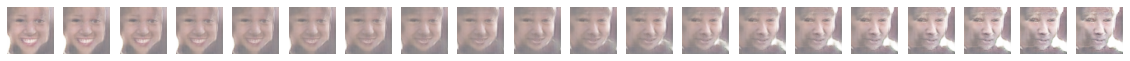

In [35]:
# < YOUR CODE STARTS HERE >

v1 = tf.random.normal([1, 100])
v2 = tf.random.normal([1, 100])

# < YOUR CODE ENDS HERE >
show_interpolation(v1, v2, gan.generator)
print(v1.shape)

## b) Поиск вектора улыбки

Придумайте каким образом найти *вектор улыбки* в латентном пространстве и докажите визуально, что это именно он -- превратив нейтрального человека в улыбающегося и наоборот.

*Вам могут пригодится функции generate_many и show-interpolation*

Результат должен получиться похожим на:

<img alt="smile.png" src="https://sun9-51.userapi.com/c857228/v857228713/aea82/t93eL7L3zbU.jpg">  
Если затрудняетесь – ниже есть подсказка. Но обязательно сначала подумайте над задачей сами)

In [19]:
# < YOUR CODE STARTS HERE >

array([[-0.29446653, -0.4346673 ,  0.3192555 , ..., -0.27860186,
        -1.4540141 ,  1.3244722 ],
       [-0.3856978 , -0.3425555 ,  0.53764266, ..., -0.1944033 ,
         1.5339301 , -0.98512006],
       [ 0.02309712,  0.97869945, -0.30560997, ...,  0.03854823,
        -0.8263133 ,  0.6175271 ],
       ...,
       [ 1.6091073 , -0.2862485 , -0.13608892, ..., -0.23628518,
        -1.0620307 ,  0.13073458],
       [ 0.7685136 , -2.63615   , -0.43045905, ..., -2.166746  ,
         0.2535619 ,  0.4177199 ],
       [ 0.52542096, -2.4851127 , -1.2552168 , ..., -0.4632258 ,
        -0.04694847,  0.964314  ]], dtype=float32)

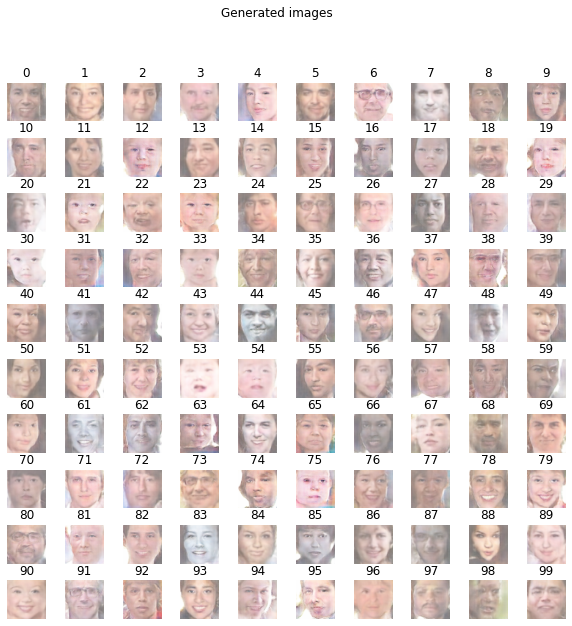

In [20]:
# поиск вектора улыбки
gen_face = generate_many(gan.generator, 100) # генерация 100 лиц
gen_face

In [38]:
list_fsmile = [15,36,43,99,90,61,83,31,11,0] # лица с улыбкой
list_fneutral = [60,45,49,29,23,2,10,9,16,55] # лица без улыбки

def mean_vector(list_):
    """
    Функция поиска среднего вектора

    """
    sum_vector = 0
    for number in list_:
      sum_vector += gen_face[number]
    mean_vec = sum_vector/len(list_)
    mean_vec = mean_vec.reshape(1,100)

    return  mean_vec


smile_face = mean_vector(list_fsmile) # средний вектор лица с улыбкой
neutral_f = mean_vector(list_fneutral) # средний вектор лица без улыбки
smile_vec = smile_face - neal_face # вектор улыбки!!!


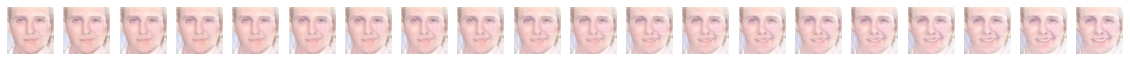

In [44]:
# нейтральный человек ------> с улыбкой
v1 = gen_face[71] # пример лица без улыбки
show_interpolation(v1, v1 + smile_vec, gan.generator)

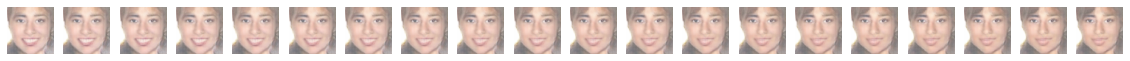

In [45]:
# человек с улыбкой ------> нейтральный
v2 = gen_face[93] # пример лица с улыбкой
show_interpolation(v2, v2 - smile_vec, gan.generator)

In [ ]:
# < YOUR CODE ENDS HERE >

In [ ]:
#@title Подсказка (спойлер). Нажмите дважды чтобы открыть { display-mode: "form" }
"""
Для выполнения задания воспользуйтесь функцией generate_many 
для того чтобы получить 100 сгенерированных изображений
и соответствующие им вектора (их вернет эта функция).

Вы увидите, что лица пронумерованы и среди них есть лица
с улыбкой. выберите около 10 лиц с улыбкой и 10 без,
запомните их номера. Затем посчитайте средний вектор
лица без улыбки и средний вектор лица с улыбкой. Разница
между ними и будет искомым вектором. 
"""


## Бонусное задание

Есть несколько вариантов выполнения бонусного задания, оно необязательное, но поможет вам глубже погрузиться в тему:

1.  Как вы обратили внимание, мы работали с картинками очень маленького разрешения  -- 32x32. Это было сделано для ускорения вычислений. Попробуйте обучить модель 64x64. Это может занять гораздо больше времени. У авторов https://github.com/znxlwm/pytorch-MNIST-CelebA-GAN-DCGAN на обучение ушло около 4 часов. Вы можете использовать датасет, [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) использованный ими. Или https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/ .
2.  Проявите креатив. Обучите GAN для новых данных. Например, для генерации [мордочек кошек](https://ajolicoeur.wordpress.com/cats/) (по ссылке несколько практических рекомендаций по обучению GAN вообще и некоторые более новые архитектуры), [персонажей аниме](https://github.com/Mckinsey666/Anime-Face-Dataset) и тд. Вы можете изменять имеющийся код (делайте это ниже) или использовать сторонние реализации при обязательном цитировании источников.
